In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from utils.load_data import *
from utils.remove_folder import *
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
import datetime

In [2]:
#Create SparkSession 
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("PySpark project") \
      .getOrCreate()

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY") #to avoid any date conversion issue


## QUESTION 1 : For each country, calculate the mean number of confirmed cases daily for each month in the dataset


In [3]:
#Store the csv into df
data_path = "data"  
df = load_csv_from_cleaned_folder(spark, data_path)
df.show(5)

+--------------+--------------+-----------+---------+--------+---------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----

In [4]:
#get the list of date columns (assuming the 7th column onwards are date columns)
date_columns = df.columns[6:]  

#converting from wide to long format for the dates
df_pivot = df.select(
    "Country/Region", 
    F.explode(
        F.array([
            F.struct(F.lit(c).alias("date"), F.col(c).alias("cases"))
            for c in date_columns
        ])
    ).alias("date_cases")
).select("Country/Region", "date_cases.*")

#Converting string dates to date type with the correct format
df_pivot = df_pivot.withColumn("date", F.to_date(F.col("date"), "MM/dd/yy"))


#extracting year and month number from the date for grouping
df_pivot = df_pivot.withColumn("year", F.year(F.col("date")))
df_pivot = df_pivot.withColumn("month", F.month(F.col("date")))  
print(df_pivot.show(5))

#grouping by country, year, and month to calculate the mean cases
#mean should be calculated on daily data, hence count distinct dates for each group
df_daily_stats = df_pivot.groupBy("Country/Region", "year", "month").agg(
    (F.sum("cases") / F.countDistinct("date")).alias("mean_cases")
)

df_daily_stats.show(5)




+--------------+----------+-----+----+-----+
|Country/Region|      date|cases|year|month|
+--------------+----------+-----+----+-----+
|   Afghanistan|2020-01-22|    0|2020|    1|
|   Afghanistan|2020-01-23|    0|2020|    1|
|   Afghanistan|2020-01-24|    0|2020|    1|
|   Afghanistan|2020-01-25|    0|2020|    1|
|   Afghanistan|2020-01-26|    0|2020|    1|
+--------------+----------+-----+----+-----+
only showing top 5 rows

None
+--------------------+----+-----+------------------+
|      Country/Region|year|month|        mean_cases|
+--------------------+----+-----+------------------+
|         Afghanistan|2020|    5|7184.5161290322585|
|             Andorra|2022|    1|30061.967741935485|
|   Equatorial Guinea|2020|    9| 4999.166666666667|
|             Burundi|2021|    9|14466.033333333333|
|Winter Olympics 2022|2022|    5|             535.0|
+--------------------+----+-----+------------------+
only showing top 5 rows



In [5]:
#convert month number to month Name
month_df = df_pivot.select(
    F.month("date").alias("month_num"), 
    F.date_format(F.col("date"), "MMMM").alias("month_name")
).distinct()


#joining to get month names
result_df = df_daily_stats.join(month_df, df_daily_stats.month == month_df.month_num)


In [6]:
#selecting the usefull cols
result_df = result_df.select(
    "Country/Region", 
    "year", 
    "month_name", 
    "mean_cases"
)

#sorting the result by "Country/Region", then year, then month
result_df = result_df.orderBy("Country/Region", "year", "month_num")

result_df.show(50)

+--------------+----+----------+------------------+
|Country/Region|year|month_name|        mean_cases|
+--------------+----+----------+------------------+
|   Afghanistan|2020|   January|               0.0|
|   Afghanistan|2020|  February|1.0344827586206897|
|   Afghanistan|2020|     March|36.806451612903224|
|   Afghanistan|2020|     April|             838.4|
|   Afghanistan|2020|       May|7184.5161290322585|
|   Afghanistan|2020|      June|25056.166666666668|
|   Afghanistan|2020|      July| 34819.74193548387|
|   Afghanistan|2020|    August| 37583.83870967742|
|   Afghanistan|2020| September| 38880.03333333333|
|   Afghanistan|2020|   October|40215.967741935485|
|   Afghanistan|2020|  November|43462.166666666664|
|   Afghanistan|2020|  December| 49662.93548387097|
|   Afghanistan|2021|   January| 53911.58064516129|
|   Afghanistan|2021|  February| 55467.92857142857|
|   Afghanistan|2021|     March| 56034.45161290323|
|   Afghanistan|2021|     April|57775.333333333336|
|   Afghanis

In [7]:

rm_dir("query_results", "*_query1")

#write result_df to csv
today = datetime.date.today().strftime("%Y%m%d")
file_path = os.path.join("query_results", f"{today}_query1")


result_df.write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").save(file_path)
print(f"Saved : {file_path}")


Removed old directory: query_results/20231109_query1
Saved : query_results/20231118_query1


### Let's do data visualisation

/tmp/ipykernel_2442/987866424.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pandas_df['Date'] = pd.to_datetime(pandas_df['year'].astype(str) + ' ' + pandas_df['month_name'])


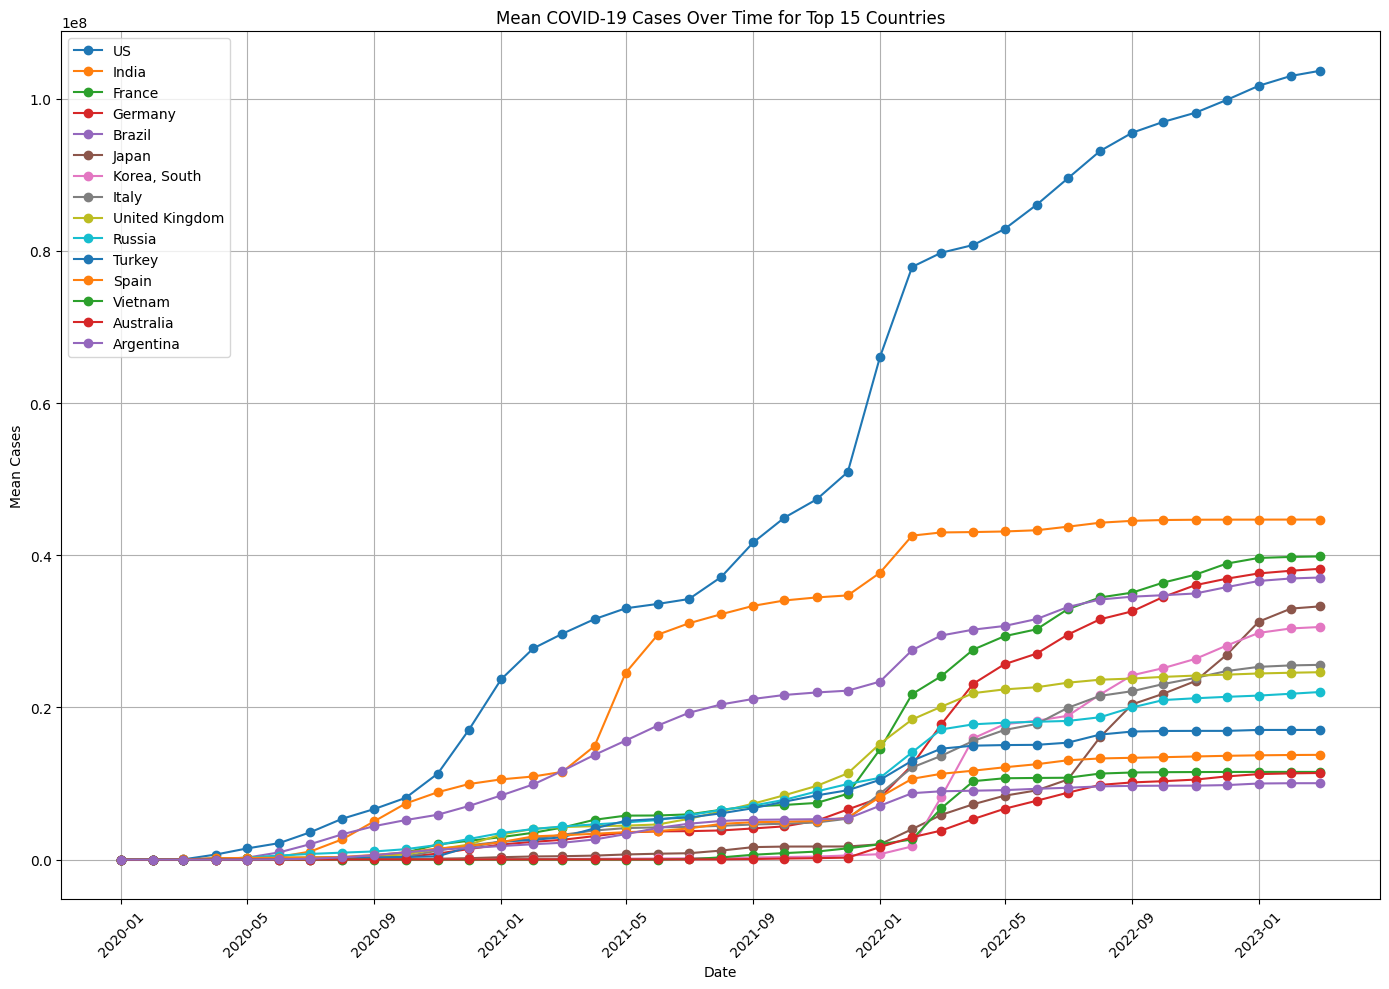

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = result_df.toPandas()

#combine 'year' and 'month_name' into a single 'Date' column for easier plotting
pandas_df['Date'] = pd.to_datetime(pandas_df['year'].astype(str) + ' ' + pandas_df['month_name'])

#sort the DataFrame by 'Date' for each 'Country/Region'
pandas_df.sort_values(by=['Country/Region', 'Date'], inplace=True)

#find the latest month for each country
latest_dates = pandas_df.groupby('Country/Region')['Date'].max().reset_index()

#merge to get the mean_cases for the latest month of each country
latest_means = latest_dates.merge(pandas_df, on=['Country/Region', 'Date'], how='left')

#get the top 15 countries by mean_cases
top_countries = latest_means.nlargest(15, 'mean_cases')['Country/Region']
top_countries_df = pandas_df[pandas_df['Country/Region'].isin(top_countries)]

plt.figure(figsize=(14, 10))

#loop through the top 15 countries/regions and plot its data
for country_region in top_countries:
    country_region_df = top_countries_df[top_countries_df['Country/Region'] == country_region]
    plt.plot(country_region_df['Date'], country_region_df['mean_cases'], marker='o', label=country_region)

plt.title('Mean COVID-19 Cases Over Time for Top 15 Countries')
plt.xlabel('Date')
plt.ylabel('Mean Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()
